In [1]:
import os
import glob
import re
import math
from io import StringIO
import numpy as np
import pandas as pd
import pyblock
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker  # Importa il modulo ticker
from scipy.optimize import curve_fit

from myfit import *
#from myfunctions import *

In [2]:
equil_time_au = 10.
#pickunits = 'au'
pickunits = 'kcal/mol'

conv2au = {
        'au':1.0,
        'eV':27.21138505,
        'kcal/mol':627.503,
        'kJ/mol':2625.5,
        'cm^-1':219474.63,
        'K': 315777.,
        'J': 43.60E-19,
        'Hz':6.57966E+15,
        }

results = {}

#os.getcwd()
dir_analysis = %pwd 
#dirdata = '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/'
dirfigs = '/Users/zen/WORK/2021_S66/ANALYSIS/EXAMPLES/20/ANALYSIS/FIGS'
dirtabs = '/Users/zen/WORK/2021_S66/ANALYSIS/EXAMPLES/20/ANALYSIS/TABS'

print(dir_analysis)

/Users/zen/Dropbox/WORK/2021_S66/ANALYSIS/EXAMPLES/20/ANALYSIS


# SYSTEM: 20_AcOH-AcOH

AB = AcOH-AcOH

A = AcOH

B = AcOH

# Read all DMC results

In [3]:
sys = {
    'A' : 'AcOH',
    'B' : 'AcOH',
}
sys['AB'] = f'{sys["A"]}+{sys["B"]}' 
sys

{'A': 'AcOH', 'B': 'AcOH', 'AB': 'AcOH+AcOH'}

In [4]:
def read_qmcpack_results( datadir, outfile, equil=5.0, giventau=np.NaN ):
    os.chdir( datadir )
    print(os.getcwd())
    res = {}
    if (os.path.isfile( outfile )):
        n = 0
        find_tau = 0
        find_taueff = 0
        tau = 0.
        taueff = 0.
        with open( outfile, 'r') as fp:
            for line in fp:
                if re.search('File Root ', line):
                    i = n
                    n += 1
                    find_tau = 0
                    find_taueff = 0
                    name = line.split()[2]
                    res[i] = { 'name' : name }
                if re.search('  time step  ',line):
                    #print(line)
                    find_tau += 1
                    if find_tau==1:
                        tau = float( line.split()[-1] )
                        res[i]['tau'] = tau
                        print(f'tau({i}) = {tau}')
                if re.search('effective time step',line):
                    #print(line)
                    find_taueff += 1
                    if find_taueff==2:
                        taueff = float( line.split()[-1] )
                        res[i]['taueff'] = taueff
                        print(f'taueff({i}) = {taueff}')
    #print(res)
    # check no missing data
    for i in res:
        if not( 'tau' in res[i]):
            res[i]['taueff'] = np.NaN
            if giventau > 0.0:
                res[i]['tau'] = giventau / 2**(i-1)
            else:
                res[i]['tau'] = 0.5 * res[i-1]['tau']
    for i in res:
        print(res[i])
    # analyse DMC data
    table = []
    for i in res:
        if i>0:
            tau = res[i]['tau']
            try:
                taueff = res[i]['taueff']
            except:
                taueff = tau
            name = res[i]['name']
            dmcfile = f'{name}.dmc.dat'
            dmc = np.loadtxt( dmcfile )
            equilibration = int( equil / tau )
            data = dmc[equilibration:,1]
            print(f' Tot. data = {len(dmc)} steps ')
            print(f' Equilibration = {equilibration} steps = {100*equilibration/len(data):2.2f}% of data')
            reblock_data = pyblock.blocking.reblock( data )
            energy = float(reblock_data[0][2])   # use all data
            opt = pyblock.blocking.find_optimal_block( len(data), reblock_data )
            print(f' opt = {opt}')
            try:
                block_size = 2**reblock_data[opt[0]][0]
                print(f' block_size={block_size}')
                energy_error = float(reblock_data[opt[0]][4])
                energy_error_error = float(reblock_data[opt[0]][5])
                print(f' reblock_data[opt[0]] ',reblock_data[opt[0]])
            except:
                print(f'Cannot find optimal block automatically, uso equilibrazione')
                logblock = int( np.log2(equilibration))
                block_size = 2**( logblock )
                print(f' block_size={block_size}')
                energy_error = float(reblock_data[logblock][4]) # np.NaN
                energy_error_error = float(reblock_data[logblock][5]) # np.NaN
                print(f' reblock_data[logblock] ',reblock_data[logblock])
            #print(f'{tau:8.5f} \t {energy} \t {energy_error} \t {energy_error_error}')
            Nsteps = len(dmc)
            Variance = np.mean(dmc[equilibration:,2])
            NumOfWalkers = np.mean(dmc[equilibration:,4])
            table.append( [tau, taueff, energy, energy_error, energy_error_error, Nsteps, NumOfWalkers, Variance] )
            #if ( energy_error < 1.e-0 ):
            #    res[tau] = { 'ene': energy, 'err': energy_error }
            #else:
            #    print(f'Error is too large for tau={tau} in {filename}!')
    # Create dataframe
    #print(np.array(table))
    df = pd.DataFrame(table, columns=['tau','taueff','ene','err','errerr','Nsteps', 'NumOfWalkers','Variance'])
    df.index = df.tau
    return df



In [16]:
runs = {
    'LDA_AE_a5z'  : { 
        'color' : 'red',
        'paths' : { n : os.path.join('/Users/zen/WORK/2021_S66/DATA_e865_QMCP/',f'S66_QMCP_AE_test/runs/20/{n}/augccpv5z') for n in ['A','B','AB']},
        'pattern' : 'dmc_J3_*',
        'outfile' : 'dmc.output'},
    'LDA_ccECP_a6z_TM' : {
        'color' : 'blue',
        'paths' : { n : os.path.join('/Users/zen/WORK/2021_S66/DATA_e865_QMCP/',f'S66_QMCP_test/runs/20/{n}/augccpv6z') for n in ['A','B','AB']},
        'pattern' : 'py_dmc_J3TM_*',
        'outfile' : 'dmcTM.output' },
    'PBE_ccECP_a6z_TM' : {
        'color' : 'cyan',
        'paths' : { n : os.path.join('/Users/zen/WORK/2021_S66/DATA_e865_QMCP/',f'S66_QMCP_PBE/runs/20/{n}/augccpv6z') for n in ['A','AB']},
        'pattern' : 'dmc_J3TM_*',
        'outfile' : 'dmcTM.output' },
    'PBE0_ccECP_a6z_TM' : {
        'color' : 'green',
        'paths' : { n : os.path.join('/Users/zen/WORK/2021_S66/DATA_e865_QMCP/',f'S66_QMCP_PBE0/runs/20/{n}/augccpv6z') for n in ['A','AB']},
        'pattern' : 'dmc_J3TM_*',
        'outfile' : 'dmcTM.output' },
}

runs

{'LDA_AE_a5z': {'color': 'red',
  'paths': {'A': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z',
   'B': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/B/augccpv5z',
   'AB': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/AB/augccpv5z'},
  'pattern': 'dmc_J3_*',
  'outfile': 'dmc.output'},
 'LDA_ccECP_a6z_TM': {'color': 'blue',
  'paths': {'A': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_test/runs/20/A/augccpv6z',
   'B': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_test/runs/20/B/augccpv6z',
   'AB': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_test/runs/20/AB/augccpv6z'},
  'pattern': 'py_dmc_J3TM_*',
  'outfile': 'dmcTM.output'},
 'PBE_ccECP_a6z_TM': {'color': 'cyan',
  'paths': {'A': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_PBE/runs/20/A/augccpv6z',
   'AB': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_PBE/runs/20/AB/augccpv6z'},
  'pattern': 'dmc_J3TM_*',
  'outfile': 'dmcTM.output'

In [17]:
runs['LDA_AE_a5z']['paths']

{'A': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z',
 'B': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/B/augccpv5z',
 'AB': '/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/AB/augccpv5z'}

In [18]:
dfs_Etot = {}

for method in runs:
    print(method)
    dfs = {}
    for sys,path in runs[method]['paths'].items():
        print(f'*** reading data in: {path} ***')
        pattern = runs[method]['pattern']
        outfile = runs[method]['outfile']
        dirs = [d for d in glob.glob(os.path.join(path, pattern)) if os.path.isdir(d)]
        [print(dirdmc) for dirdmc in dirs]
        #taus = [d.split('_')[-1] for d in glob.glob(os.path.join(path, pattern)) if os.path.isdir(d)]
        dfs[sys] = pd.concat( [
            read_qmcpack_results( dirdmc, outfile, equil=10.) 
            for dirdmc in dirs
        ])
    # merge dataframes in only one with all data
    df = pd.concat( dfs, axis=1 )
    df.sort_index(inplace=True)
    # Compute the interaction energy in kcal/mol as 
    #    Eint = E[AB] - 2 E[A]
    unit = 'kcal/mol'
    c=conv2au[unit] 
    df[('Eint','ene')] =  c * ( df[('AB','ene')] - 2 * df[('A','ene')] )
    df[('Eint','err')] =  c * ( df[('AB','err')]**2 + 4 * df[('A','err')]**2 )**0.5
    df[('Eint','unit')] = unit
    # copy in a dictionary of dataframes
    dfs_Etot[method] = df.copy()
    # write data in a table
    df.to_csv( os.path.join( dirtabs, f'tag_{method}.csv' ) )
    
#dfs
os.chdir( dir_analysis )
os.getcwd()

LDA_AE_a5z
*** reading data in: /Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z ***
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.008
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.006
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.001
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.007
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.009
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.02
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.05
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.1
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J3_0.04
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_AE_test/runs/20/A/augccpv5z/dmc_J

/Users/zen/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


 Tot. data = 30000 steps 
 Equilibration = 3333 steps = 12.50% of data
 opt = [9]
 block_size=512
 reblock_data[opt[0]]  BlockTuple(block=9, ndata=52, mean=array(-45.83713722), cov=array(5.25155326e-07), std_err=array(0.00010049), std_err_err=array(9.95043643e-06))
/Users/zen/Dropbox/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_test/runs/20/A/augccpv6z/py_dmc_J3TM_0.002
tau(0) = 0.1
tau(1) = 0.002
taueff(1) = 0.00199771
{'name': 'dmcTM.s000', 'tau': 0.1}
{'name': 'dmcTM.s001', 'tau': 0.002, 'taueff': 0.00199771}
 Tot. data = 150000 steps 
 Equilibration = 5000 steps = 3.45% of data
 opt = [11]
 block_size=2048
 reblock_data[opt[0]]  BlockTuple(block=11, ndata=70, mean=array(-45.83675939), cov=array(3.51078681e-07), std_err=array(7.08195575e-05), std_err_err=array(6.02856109e-06))
/Users/zen/Dropbox/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_test/runs/20/A/augccpv6z/py_dmc_J3TM_0.005
tau(0) = 0.1
tau(1) = 0.005
taueff(1) = 0.00498044
{'name': 'dmcTM.s000', 'tau': 0.1}
{'name': 'dmcTM.s001', 'tau': 

/Users/zen/.pyenv/versions/3.10.9/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


 Tot. data = 100000 steps 
 Equilibration = 1000 steps = 1.01% of data
 opt = [9]
 block_size=512
 reblock_data[opt[0]]  BlockTuple(block=9, ndata=193, mean=array(-45.83839324), cov=array(1.91382969e-07), std_err=array(3.14900238e-05), std_err_err=array(1.60696855e-06))
/Users/zen/Dropbox/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_PBE/runs/20/A/augccpv6z/dmc_J3TM_0.06
tau(0) = 0.1
tau(1) = 0.06
taueff(1) = 0.0548754
{'name': 'dmcTM.s000', 'tau': 0.1}
{'name': 'dmcTM.s001', 'tau': 0.06, 'taueff': 0.0548754}
 Tot. data = 16000 steps 
 Equilibration = 166 steps = 1.05% of data
 opt = [7]
 block_size=128
 reblock_data[opt[0]]  BlockTuple(block=7, ndata=123, mean=array(-45.84803357), cov=array(1.82641996e-07), std_err=array(3.85343259e-05), std_err_err=array(2.46690743e-06))
*** reading data in: /Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_PBE/runs/20/AB/augccpv6z ***
/Users/zen/WORK/2021_S66/DATA_e865_QMCP/S66_QMCP_PBE/runs/20/AB/augccpv6z/dmc_J3TM_0.1
/Users/zen/WORK/2021_S66/DATA_e865_QMC

'/Users/zen/Dropbox/WORK/2021_S66/ANALYSIS/EXAMPLES/20/ANALYSIS'

In [19]:
dfs_Etot.keys()

dict_keys(['LDA_AE_a5z', 'LDA_ccECP_a6z_TM', 'PBE_ccECP_a6z_TM', 'PBE0_ccECP_a6z_TM'])

In [20]:
dfs_Etot['LDA_ccECP_a6z_TM']

A                                                                  \
         tau    taueff        ene       err    errerr  Nsteps   NumOfWalkers   
tau                                                                            
0.002  0.002  0.001998 -45.836756  0.000071  0.000006  150000  102386.322372   
0.003  0.003  0.002994 -45.837137  0.000100  0.000010   30000  102384.247084   
0.005  0.005  0.004980 -45.837565  0.000082  0.000008   30000  102357.393786   
0.007  0.007  0.006957 -45.838058  0.000083  0.000008   30000  102290.271455   
0.010  0.010  0.009903 -45.838866  0.000072  0.000006   20000  102254.087263   
0.015  0.015  0.014756 -45.840047  0.000063  0.000005   19800  102169.837462   
0.020  0.020  0.019533 -45.841299  0.000045  0.000003   30000  102093.597220   
0.030  0.030  0.028850 -45.843486  0.000077  0.000008    7000  101922.333733   
0.040  0.040  0.037846 -45.845772  0.000034  0.000002   30000  101693.022588   
0.060  0.060  0.054878 -45.850023  0.000026  0.000001   30000  101264.894784   
0.100  0.100  0.085328 -45.858089  0.000094  0.000009    2000  100442.678947   

                    B            ...        AB                                 \
       Variance   tau    taueff  ...    taueff        ene       err    errerr   
tau                              ...                                            
0.002  0.655008   NaN       NaN  ...  0.001998 -91.705781  0.000170  0.000020   
0.003  0.657154   NaN       NaN  ...  0.003000 -91.706063  0.000177  0.000021   
0.005  0.663027   NaN       NaN  ...  0.005000 -91.707175  0.000167  0.000019   
0.007  0.666303   NaN       NaN  ...  0.007000 -91.708137  0.000120  0.000013   
0.010  0.672168  0.01  0.009903  ...  0.009903 -91.709769  0.000111  0.000009   
0.015  0.681302   NaN       NaN  ...  0.014755 -91.712269  0.000084  0.000007   
0.020  0.687259   NaN       NaN  ...  0.020000 -91.714705  0.000069  0.000005   
0.030  0.698787  0.03  0.028850  ...  0.028847 -91.719453  0.000116  0.000012   
0.040  0.709381   NaN       NaN  ...  0.040000 -91.724207  0.000054  0.000003   
0.060  0.726734   NaN       NaN  ...  0.060000 -91.733198  0.000048  0.000003   
0.100  0.752134  0.10  0.085325  ...  0.085295 -91.750331  0.000116  0.000011   

                                            Eint                      
      Nsteps   NumOfWalkers  Variance        ene       err      unit  
tau                                                                   
0.002  45500  102471.007185  1.314260 -20.249157  0.139053  kcal/mol  
0.003  23168  102406.190976  1.318604 -19.947756  0.168191  kcal/mol  
0.005  23361  102380.135527  1.327995 -20.109029  0.146919  kcal/mol  
0.007  23448  102304.941508  1.336797 -20.093354  0.128925  kcal/mol  
0.010  20000  102311.870579  1.349063 -20.102993  0.113922  kcal/mol  
0.015  19800  102181.297272  1.368637 -20.189274  0.095010  kcal/mol  
0.020  23359  102092.753533  1.381303 -20.147652  0.070963  kcal/mol  
0.030   7000  101919.385031  1.409006 -20.381863  0.120678  kcal/mol  
0.040  23454  101681.052017  1.430617 -20.495784  0.054118  kcal/mol  
0.060  23529  101210.077088  1.466547 -20.803164  0.044719  kcal/mol  
0.100   2000  100230.008947  1.516485 -21.430545  0.138852  kcal/mol  

[11 rows x 27 columns]

# Figures

In [21]:
#from ipywidgets import interact, FloatSlider
%matplotlib widget
import matplotlib.pyplot as plt

Fit with polynomial function of degree 2
popt = [ -20.33284649   82.36483693 -223.41583252]
perr = [1.37281098e-01 1.70689432e+01 3.72639960e+02]
pcov = [[ 1.88460998e-02 -2.10739115e+00  4.12792818e+01]
 [-2.10739115e+00  2.91348820e+02 -6.14013701e+03]
 [ 4.12792818e+01 -6.14013701e+03  1.38860540e+05]]

Etot = -20.33285 +/- 0.13728
   Chi-quadro = 19.175 
   ndof = 14 
   Chi-quadro Ridotto = 1.370 
   p-value=0.158




Fit with polynomial function of degree 2
popt = [-20.01650528 -10.08750235 -45.66145616]
perr = [ 0.04982864  2.52143873 28.53767256]
pcov = [[ 2.48289318e-03 -1.05745677e-01  9.55630956e-01]
 [-1.05745677e-01  6.35765329e+00 -6.79404133e+01]
 [ 9.55630956e-01 -6.79404133e+01  8.14398755e+02]]

Etot = -20.01651 +/- 0.04983
   Chi-quadro = 4.685 
   ndof = 8 
   Chi-quadro Ridotto = 0.586 
   p-value=0.791




Fit with polynomial function of degree 2
popt = [-19.93800879 -11.81233847   2.00553112]
perr = [ 0.15044573  6.8414678  59.84918694]
pcov = [[ 2.26339174e-02 -

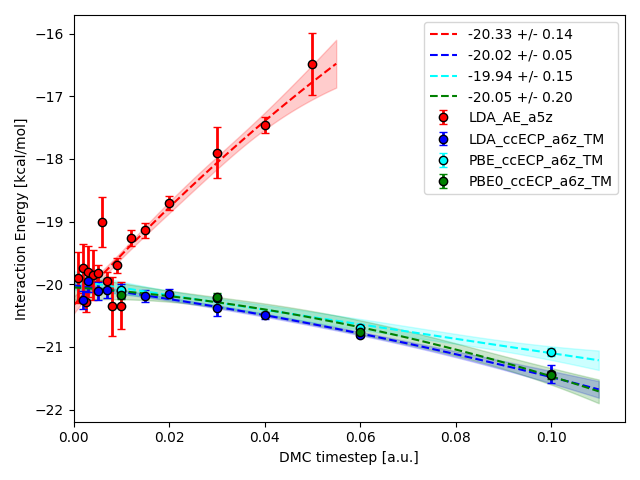

In [34]:
makefit = True
makefiterr=True

plt.figure()
#plt.title(f'{mol} : {sys[mol]}')

# Disabilita l'offset nell'asse y
ax = plt.gca()  # Accedi agli assi correnti
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))

for method, df in dfs_Etot.items():
    df = df['Eint'].copy()
    df.drop( df[ df.loc[:,'err'] > 1.e0 ].index, inplace=True )
    df.dropna( inplace=True )
    #print(df)
    color = runs[method]['color']
    
    plt.errorbar(df.index, df.ene, df.err, label=method,
                 color = color,
                 ls="", marker='o', mec='k', elinewidth=2, capsize=3)
    if makefit:
        xdata = df.index.to_numpy()
        ydata = df.ene.to_numpy()
        sigma = df.err.to_numpy()
        for degn in [3]:
            try:
                fitfun = fun_poly
                initial_guess = -0.1*np.ones(degn)
                initial_guess[0] = np.mean(ydata)
                #initial_guess = 0.01*np.random.randn(degn)
                print(f'Fit with polynomial function of degree {degn-1}')
                popt, pcov = curve_fit( fitfun, xdata=xdata, ydata=ydata, sigma=sigma, p0=initial_guess )
                popterr = np.array([pcov[i,i] for i in range(len(pcov))])**0.5
                print( f'popt = {popt}' )
                print( f'perr = {popterr}' )
                print( f'pcov = {pcov}\n' )
                print( f'Etot = {popt[0]:9.5f} +/- {popterr[0]:6.5f}')
                xlinspace = np.linspace( 0, 1.1*max(xdata), 100)
                funlinspace = fitfun( xlinspace, *popt )
                plt.plot(xlinspace, funlinspace,
                         '--', color=color,
                         label = f'{popt[0]:6.2f} +/- {popterr[0]:3.2f}' #f'poly{degn}' 
                        )
                if makefiterr:
                    var_y = fun_var_y( xlinspace, pcov )
                    err_y = var_y**0.5
                    plt.fill_between(xlinspace,
                                     funlinspace-1*err_y,
                                     funlinspace+1*err_y,
                                     alpha=0.2, 
                                     color = color,
                                    )
                chi2, ndof, p_value = get_chi2_p_value_fitfun( xdata, ydata, sigma, fitfun, popt )
                print( f'   Chi-quadro = {chi2:5.3f} \n   ndof = {ndof} \n   Chi-quadro Ridotto = {chi2/ndof:5.3f} \n   p-value={p_value:5.3g}\n\n' )
            except:
                pass
    print('\n')

plt.xlabel(f'DMC timestep [a.u.]')
unit = df.unit.unique().item()
plt.ylabel(f'Interaction Energy [{unit}]')

plt.xlim(0,None)
#plt.xlim(0,0.103)
plt.legend(loc=1)
plt.tight_layout()

#os.chdir('FIGS/')
plt.savefig(f'{dirfigs}/Fig_Eint_AE.png',dpi=300)

In [35]:
os.chdir(dir_analysis)
%pwd

'/Users/zen/Dropbox/WORK/2021_S66/ANALYSIS/EXAMPLES/20/ANALYSIS'

In [37]:
# Lettura risoltati

df  = pd.read_csv( os.path.join(dirtabs,'tag_LDA_AE_a5z.csv'), header=[0, 1], index_col=0)
df

A                                                    \
           tau    taueff         ene       err    errerr  Nsteps   
tau                                                                
0.0010  0.0010  0.000995 -229.053296  0.000245  0.000027  100000   
0.0020  0.0020  0.001976 -229.051713  0.000264  0.000029   50000   
0.0025  0.0025  0.002460 -229.050941  0.000079  0.000004  400000   
0.0030  0.0030  0.002940 -229.050178  0.000270  0.000036   33300   
0.0040  0.0040  0.003888 -229.048979  0.000264  0.000029   25000   
0.0050  0.0050  0.004818 -229.047829  0.000074  0.000004  200000   
0.0060  0.0060  0.005733 -229.047204  0.000279  0.000037   16600   
0.0070  0.0070  0.006633 -229.045808  0.000077  0.000005  142000   
0.0080  0.0080  0.007519 -229.044744  0.000329  0.000052   12500   
0.0090  0.0090  0.008392 -229.044522  0.000075  0.000004  111000   
0.0100  0.0100  0.009252 -229.043932  0.000225  0.000027   10000   
0.0120  0.0120  0.010937 -229.043821  0.000082  0.000005   83000   
0.0150  0.0150  0.013389 -229.044048  0.000078  0.000005   66000   
0.0200  0.0200  0.017304 -229.046817  0.000074  0.000004   50000   
0.0300  0.0300  0.024653 -229.059039  0.000266  0.000040    3300   
0.0400  0.0400  0.031532 -229.078177  0.000077  0.000004   25000   
0.0500  0.0500  0.038053 -229.102329  0.000331  0.000045    2000   
0.0600  0.0600  0.044278 -229.130162  0.000106  0.000007   16000   
0.1000  0.1000  0.066669 -230.215395  0.141436  0.027738    1000   

                                     B            ...        AB              \
         NumOfWalkers  Variance    tau    taueff  ...    taueff         ene   
tau                                               ...                         
0.0010  102656.918078  2.946275  0.001  0.000995  ...  0.001000 -458.138302   
0.0020  102400.306800  2.944861  0.002  0.001976  ...  0.001976 -458.134894   
0.0025  102317.196008  2.938269    NaN       NaN  ...  0.002460 -458.134195   
0.0030  102316.049721  2.931922  0.003  0.002940  ...  0.002940 -458.131913   
0.0040  102284.175867  2.939692    NaN       NaN  ...  0.003888 -458.129590   
0.0050  102215.695692  2.932053    NaN       NaN  ...  0.004818 -458.127250   
0.0060  102243.157426  2.934986  0.006  0.005733  ...  0.005733 -458.124692   
0.0070  102198.158232  2.938378    NaN       NaN  ...  0.006633 -458.123392   
0.0080  102151.006667  2.918609    NaN       NaN  ...  0.007519 -458.121919   
0.0090  102137.575635  2.922582    NaN       NaN  ...  0.008392 -458.120438   
0.0100  102111.736556  2.934061  0.010  0.009252  ...  0.009252 -458.120277   
0.0120  102106.746419  2.913521    NaN       NaN  ...  0.010937 -458.118348   
0.0150  101994.655570  2.912592    NaN       NaN  ...  0.013388 -458.118597   
0.0200  101943.882727  2.902657    NaN       NaN  ...  0.017303 -458.123437   
0.0300  101815.843613  2.909395  0.030  0.024651  ...  0.024651 -458.146600   
0.0400  101655.022747  2.862132    NaN       NaN  ...  0.031528 -458.184168   
0.0500  101463.291667  2.820290  0.050  0.038047  ...  0.038048 -458.230935   
0.0600  101252.039030  2.828141    NaN       NaN  ...  0.044173 -459.281389   
0.1000  125647.334444  5.788931    NaN       NaN  ...  0.066666 -460.039497   

                                                                    Eint  \
             err    errerr  Nsteps   NumOfWalkers   Variance         ene   
tau                                                                        
0.0010  0.000426  0.000059   67300  102813.989721   5.739461  -19.897516   
0.0020  0.000326  0.000036   50000  102596.648622   5.799930  -19.746888   
0.0025  0.000219  0.000020  132400  102365.403583   5.734008  -20.276174   
0.0030  0.000355  0.000047   33300  102470.669403   5.736764  -19.801817   
0.0040  0.000367  0.000040   25000  102322.624400   5.735970  -19.848718   
0.0050  0.000143  0.000009  129200  102262.780668   5.721074  -19.823955   
0.0060  0.000299  0.000028   16600  102290.776617   5.714759  -19.003465   
0.0070  0.000143 

In [38]:
df['Eint']

,ene,err,unit
tau,,,
0.0010,-19.897516,0.407492,kcal/mol
0.0020,-19.746888,0.389640,kcal/mol
0.0025,-20.276174,0.169199,kcal/mol
0.0030,-19.801817,0.405026,kcal/mol
0.0040,-19.848718,0.403659,kcal/mol
0.0050,-19.823955,0.129218,kcal/mol
0.0060,-19.003465,0.396906,kcal/mol
0.0070,-19.939892,0.131363,kcal/mol
0.0080,-20.351375,0.467942,kcal/mol
